In [1]:
import os
import numpy as np
import glob
from tess_sip import SIP
from astropy.coordinates import SkyCoord
from astropy import units as u
import lightkurve as lk
from astroquery.mast import Tesscut
import tess_cpm
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings

sys.path.insert(0, "../")
sys.path.insert(0, "../../Packages/eleanor/")
import eleanor

# import warnings
# warnings.filterwarnings('ignore')

from michael import janet

In [2]:
uni = pd.read_csv("/Users/oliver hall/Research/unicorn/data/unicorn.csv", index_col=0)

index = uni[uni.source_id == 5310986619293965440].index[0]

Target DR3 ID 5310986619293965440 has tesscut data available on MAST for Sectors 8, 9, 10, 35, 36
Data already downloaded for Sector 8.
Data already downloaded for Sector 9.
Data already downloaded for Sector 10.
Data already downloaded for Sector 35.
Data already downloaded for Sector 36.


Running pixels in aperture: 100%|████████████| 300/300 [00:01<00:00, 245.78it/s]
/Users/oliver hall/Research/michael/Examples/../michael/janet.py:138: UserWarning: Your upper period limit is longer than half your longest set of consecutive TESS sectors. You'll be more prone to harmonics.
  warnings.warn(UserWarning("Your upper period limit is longer than half your "+
/Users/oliver hall/.conda/envs/michael10/lib/python3.10/site-packages/jazzhands/wavelets.py:488: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Period range automatically set to 0.75x the length of the longest baseline.
For this target, this is 60.75 days.
### Running Simple Astropy Lomb-Scargle on Sector 8-10 on star 5310986619293965440 ###
### Completed Simple Astropy Lomb-Scargle for Sector 8-10 on star 5310986619293965440 ###
### Running Wavelet Estimation for Sector 8-10 on star 5310986619293965440 ###


100%|███████████████████████████████████████| 1167/1167 [00:51<00:00, 22.58it/s]


### Completed Wavelet Estimation for Sector 8-10 on star 5310986619293965440 ###
### Running Composite ACF estimation for Sector 8-10 on star 5310986619293965440 ###
### Completed Composite ACF estimation for Sector 8-10 on star 5310986619293965440 ###
### Running ACF Estimation on star 5310986619293965440 ###
### Completed ACF Estimation for Sector 8-10 on star 5310986619293965440 ###
### Running Simple Astropy Lomb-Scargle on Sector 35-36 on star 5310986619293965440 ###
### Completed Simple Astropy Lomb-Scargle for Sector 35-36 on star 5310986619293965440 ###
### Running Wavelet Estimation for Sector 35-36 on star 5310986619293965440 ###


100%|█████████████████████████████████████████| 760/760 [00:50<00:00, 14.93it/s]
/Users/oliver hall/Research/michael/Examples/../michael/validate.py:173: UserWarning: One or more sectors disagree strongly across all estimates. Please inspect the results carefully yourself.
  warnings.warn("One or more sectors disagree strongly across all estimates. Please inspect the results carefully yourself.")


### Completed Wavelet Estimation for Sector 35-36 on star 5310986619293965440 ###
### Running Composite ACF estimation for Sector 35-36 on star 5310986619293965440 ###
### Completed Composite ACF estimation for Sector 35-36 on star 5310986619293965440 ###
### Running ACF Estimation on star 5310986619293965440 ###
### Completed ACF Estimation for Sector 35-36 on star 5310986619293965440 ###


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.



------ Decoding Overall Period Flag 12 ------
8: One or more sectors disagrees strongly across all estimates with the others. This may indicate signal from a background star present in those sectors.
4: Only 3 or fewer of the 4 estimates of rotation agreed with one another to within 1 sigma.

No other flags raised. 



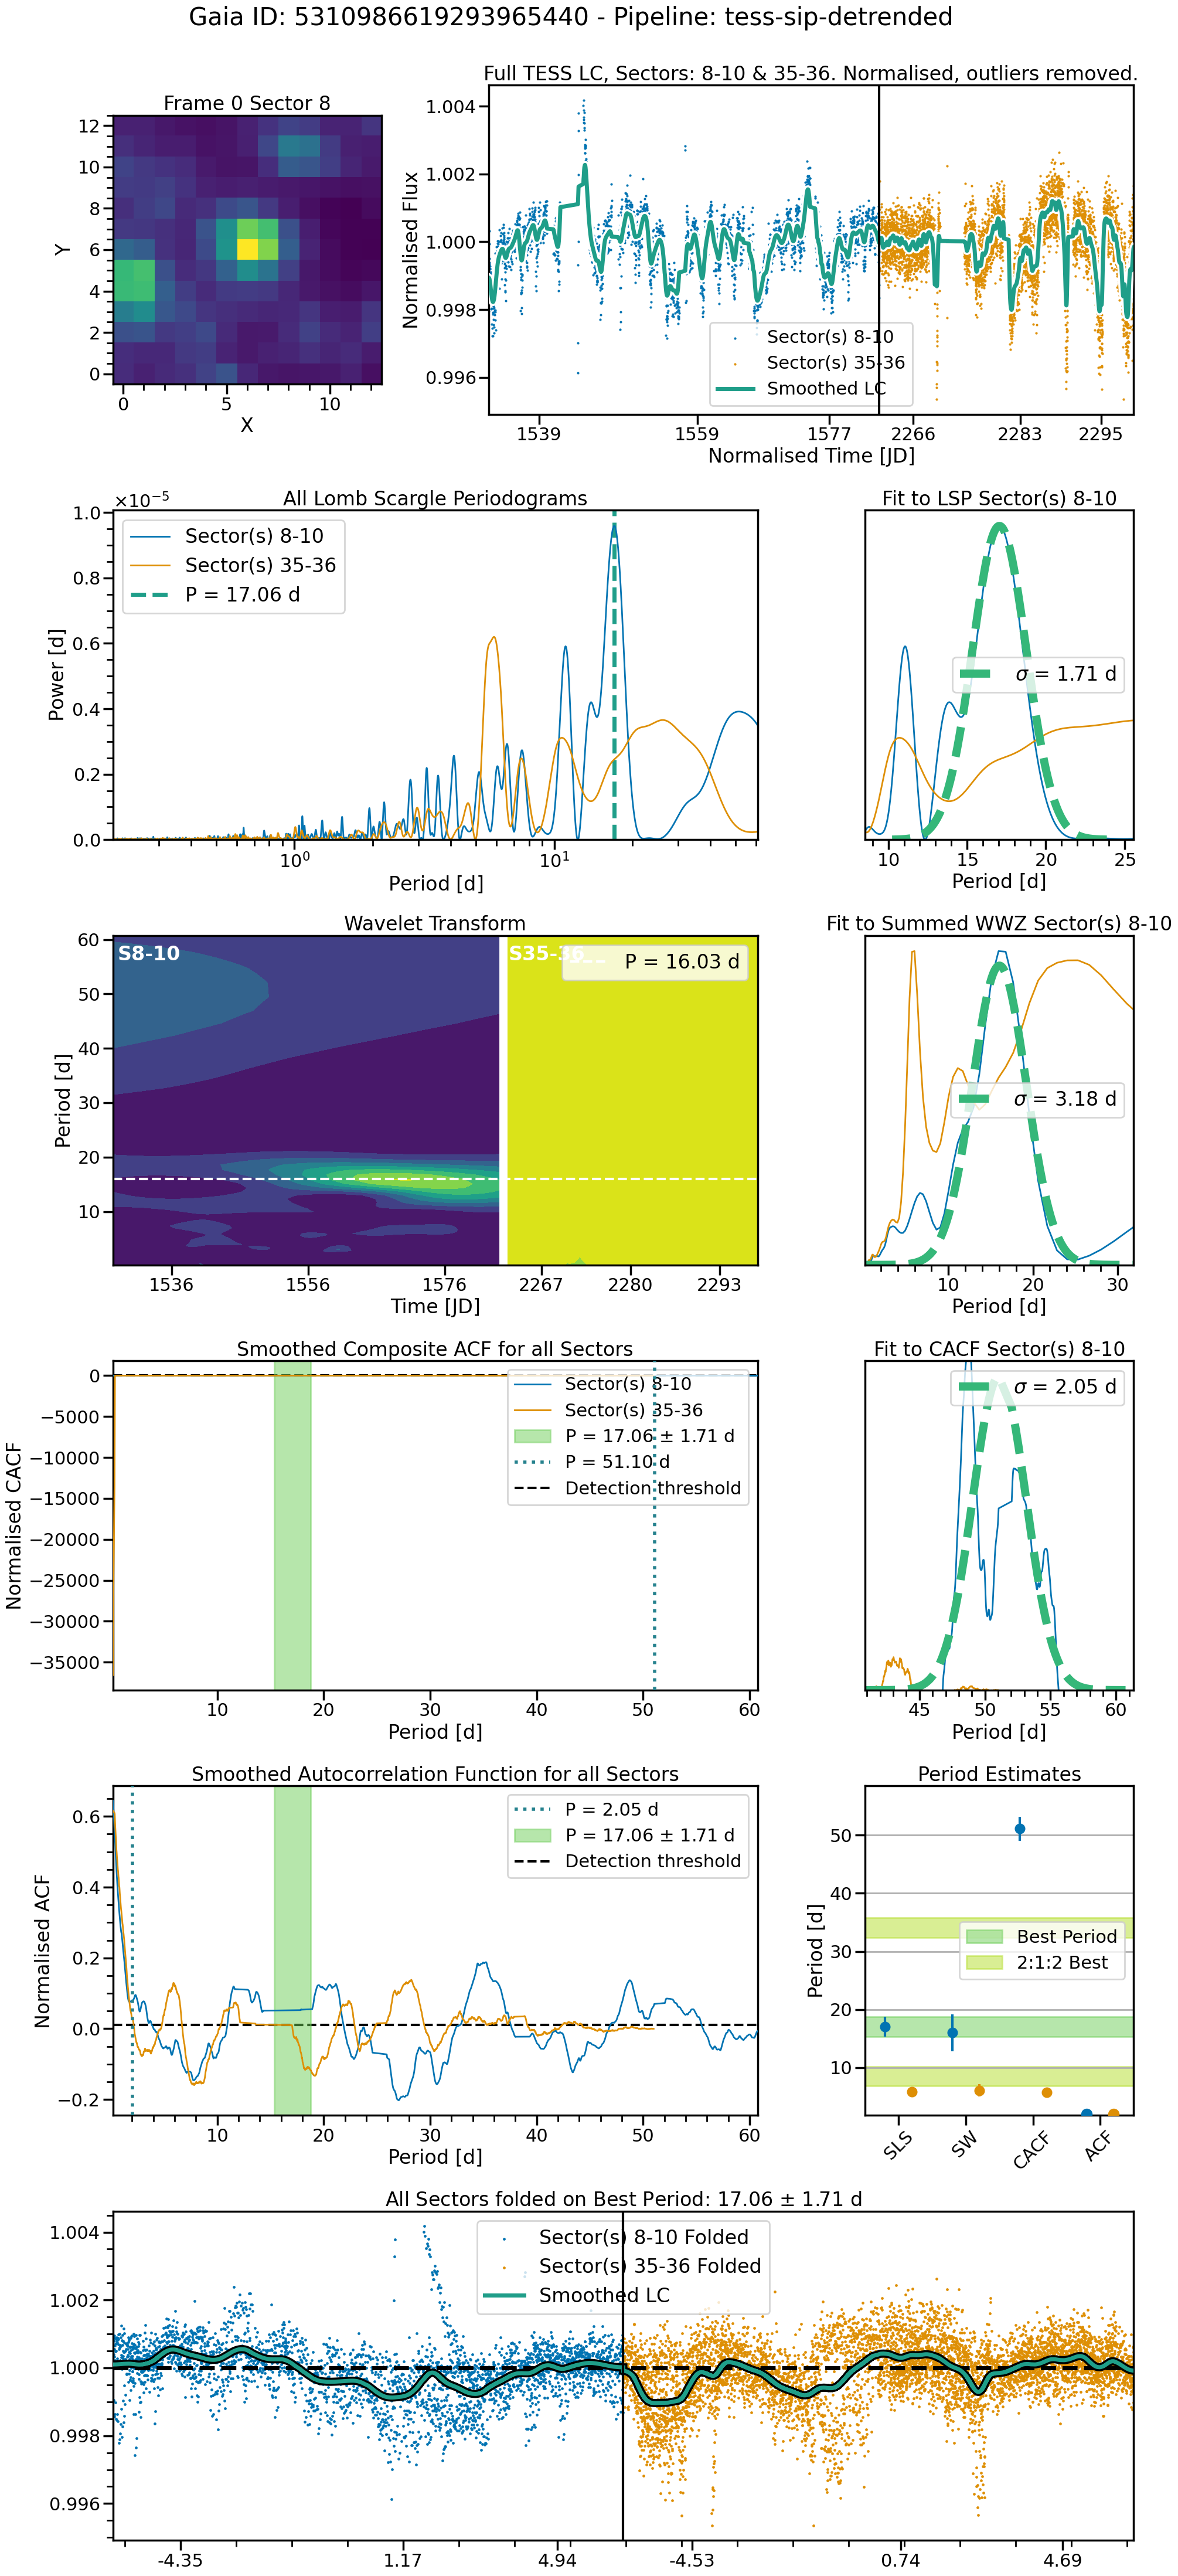

In [3]:
j = janet.boot(uni, index=index, pipeline='tess-sip-detrended')
j.run(period_range = 'auto')
plt.show()

In [4]:
j.period_range

(0.2, 60.75)

In [7]:
from michael.data import data_class
d = data_class(j)
d.setup_data()
d.build_eleanor_lc()

Target DR3 ID 5310986619293965440 has tesscut data available on MAST for Sectors 8, 9, 10, 35, 36
Data already downloaded for Sector 8.
Data already downloaded for Sector 9.
Data already downloaded for Sector 10.
Data already downloaded for Sector 35.
Data already downloaded for Sector 36.


/Users/oliver hall/Research/michael/Examples/../../Packages/eleanor/eleanor/source.py:55: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if sectors == 'all':


In [14]:
d.build_unpopular_lc()

Removing 17 bad data points (out of 968) using the TESS provided QUALITY array
Summing over 3 x 3 pixel lightcurves. Weighting=median
Removing 70 bad data points (out of 1154) using the TESS provided QUALITY array
Summing over 2 x 2 pixel lightcurves. Weighting=median
Removing 61 bad data points (out of 1211) using the TESS provided QUALITY array
Summing over 3 x 3 pixel lightcurves. Weighting=median
Removing 538 bad data points (out of 3353) using the TESS provided QUALITY array


/Users/oliver hall/.conda/envs/michael10/lib/python3.10/site-packages/tess_cpm-0.0.1-py3.10.egg/tess_cpm/cutout_data.py:102: RuntimeWarning: invalid value encountered in divide
/Users/oliver hall/.conda/envs/michael10/lib/python3.10/site-packages/tess_cpm-0.0.1-py3.10.egg/tess_cpm/cutout_data.py:108: RuntimeWarning: invalid value encountered in divide


Summing over 3 x 3 pixel lightcurves. Weighting=median
Removing 10 bad data points (out of 3477) using the TESS provided QUALITY array
Summing over 3 x 3 pixel lightcurves. Weighting=median


In [30]:
j.void['cpm_35'].cutout_data.fluxes[0]

(2815, 50, 50)

(19.0, 31.0)

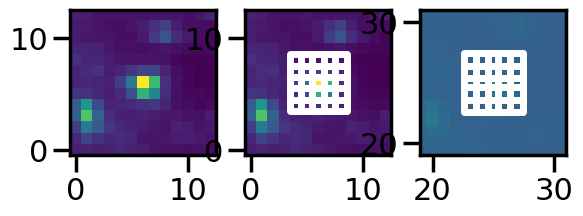

In [39]:
fig, ax = plt.subplots(1,3)
ax[0].imshow(j.void['tpfs_35-36'][0].flux.value[0], origin='lower')
ax[1].imshow(j.void['datum_35'].tpf[0], origin='lower')
pix = np.where(j.void[f'datum_35'].aperture > 0)
ax[1].scatter(pix[0], pix[1], edgecolors='w', lw=5, marker=',', facecolors='none', s=600, zorder=2, label='Aperture')
ax[2].imshow(j.void['cpm_35'].cutout_data.fluxes[0])
pix = np.where(j.void[f'cpm_35'].aperture > 0)
ax[2].scatter(pix[0], pix[1], edgecolors='w', lw=5, marker=',', facecolors='none', s=600, zorder=2, label='Aperture')
ax[2].set_xlim(19, 50-19)
ax[2].set_ylim(19, 50-19)

In [11]:
j.void['datum_35'].tpf[0]

array([[ 7353.898 ,  7394.4053,  7342.152 ,  7359.4995,  7443.605 ,
         7383.433 ,  7326.2656,  7263.997 ,  7223.034 ,  7191.9033,
         7185.66  ,  7207.269 ,  7173.5195],
       [ 7443.618 ,  7728.1323,  7559.9854,  7428.07  ,  7496.216 ,
         7426.1235,  7234.5854,  7232.93  ,  7267.199 ,  7297.705 ,
         7310.862 ,  7274.9194,  7223.2954],
       [ 7669.1978,  8420.242 ,  8019.4097,  7583.331 ,  7448.9727,
         7396.2495,  7293.9893,  7257.9463,  7241.77  ,  7379.675 ,
         7321.0356,  7245.2695,  7286.7993],
       [ 8137.327 ,  9477.861 ,  8123.8335,  7483.3203,  7351.599 ,
         7330.02  ,  7385.8984,  7308.058 ,  7279.166 ,  7285.373 ,
         7220.2983,  7189.1875,  7324.5166],
       [ 8061.279 ,  8808.973 ,  7804.8564,  7373.1274,  7399.774 ,
         7449.815 ,  7546.1953,  7601.3125,  7388.915 ,  7204.692 ,
         7170.932 ,  7121.4595,  7136.128 ],
       [ 7559.0845,  7533.99  ,  7443.162 ,  7333.8877,  7475.868 ,
         7864.342 ,  9214.9

In [ ]:
j.sectorlist

In [ ]:
j = janet.boot(uni, index=index, pipeline='eleanor')
j.run(period_range = (2, 20))
plt.show()

In [ ]:
j = janet.boot(uni, index=index, pipeline='unpopular')
j.run(period_range = (2, 20))
plt.show()